## Initialize

### Import modules

In [1]:
import datetime
import math
import os

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import shioaji as sj
import talib as ta
import torch
import wandb

from sklearn.model_selection import KFold
from tqdm import tqdm

### Hyper parameters and parameters

In [2]:
## Hyperparameters
SEQ_LEN = 120
BATCH_SIZE = 32
EPOCHS = 25
D_MODEL = 6
NUM_HEADS = 2
NUM_ENCODER_LAYERS = 6
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-4
K = 5

## Parameters
MIN_LATER = 15  # The minute we want to predict in the future
DEVICE = (torch.cuda.is_available() and 'cuda:0') or 'cpu'

BEGIN_TIME = datetime.time(9, 15)
END_TIME = datetime.time(13, 15)

### Connect with weight and bias website

In [3]:
wandb.init(
    project = "transformer",

    config = {
        "architecture": "transformer",
        "dataset": "TXF and TSMC",
        "Kbar_timeunit": "15min",
        "LOSS_FUNC": "MSE",
        "OPTIMIZER": "adam",

        "SEQ_LEN": SEQ_LEN,
        "BATCH_SIZE": BATCH_SIZE,
        "EPOCHS": EPOCHS,
        "D_MODEL": D_MODEL,
        "NUM_HEADS": NUM_HEADS,
        "NUM_ENCODER_LAYERS": NUM_ENCODER_LAYERS,
        "DROPOUT_RATE": DROPOUT_RATE,
        "LEANING_RATE": LEARNING_RATE,
        "KFold": K,

        "MIN_LATER": MIN_LATER,

        "EPSILON": 1e-8,
        "BETA": (0.9, 0.98),
        "WEIGHT_DECAY": 0.02,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: rogerline0527 (rogerline0527-national-tsing-hua-university). Use `wandb login --relogin` to force relogin


### Plot function

In [4]:
def draw_plot(x_data: pd.DataFrame, y_data: pd.DataFrame, x_label: str, y_label: str) -> None:
    fig = plt.figure(figsize=(7, 4))
    plt.scatter(x_data, y_data, s = 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### Indicators function

In [5]:
def keltner_bands(close: np.ndarray, high: np.ndarray, low: np.ndarray, period: int, multiplier: int) -> tuple:
    mid = ta.EMA(close, timeperiod = period)
    mid = np.nan_to_num(mid, nan = mid.iloc[period - 1])
    kelt_trange = np.array([])

    for i in tqdm(range(1, len(close)), desc = "Calculating kelner bands "):
        tem_trange = max(
            high.iloc[-i] - low.iloc[-i],
            abs(high.iloc[-i] - close.iloc[-i - 1]),
            abs(low.iloc[-i] - close.iloc[-i - 1])
        )
        kelt_trange = np.append(tem_trange, kelt_trange)
    kelt_trange = np.append(high.iloc[0] - low.iloc[0], kelt_trange)
    atr = ta.EMA(kelt_trange, timeperiod = period)
    atr = np.nan_to_num(atr, nan = atr[period - 1])
    upper = mid + atr * multiplier
    lower = mid - atr * multiplier

    return upper, mid, lower

In [6]:
def KDJ(high: np.ndarray, low: np.ndarray, close: np.ndarray, period: int, signal_k: int, signal_d: int) -> tuple:
    _alpha_k = 2 / (signal_k + 1)
    _alpha_d = 2 / (signal_d + 1)

    lowest = ta.MIN(low, timeperiod = period)
    lowest = np.nan_to_num(lowest, nan = lowest.iloc[period - 1])
    highest = ta.MAX(high, timeperiod = period)
    highest = np.nan_to_num(highest, nan = highest.iloc[period - 1])

    rsv = (close - lowest) / (highest - lowest) * 100
    
    K = np.array([50])
    D = np.array([50])
    J = np.array([50])
    
    for i in tqdm(range(1, len(close)), desc = "Calculating KDJ "):
        K = np.append(K, int(_alpha_k * ((K[-1] + 2 * rsv.iloc[i]) / 3) + (1 - _alpha_k) * K[-1] + 0.5))
        D = np.append(D,  int(_alpha_d * ((D[-1] + 2 * K[-1]) / 3) + (1 - _alpha_d) * D[-1] + 0.5))
        J = np.append(J, 3 * K[-1] - 2 * D[-1])

    return K, D, J

## Data preprocess

### Load data and split into train/test set

In [7]:
def load_and_check(data_path: str, start_date: datetime.date = None, end_date: datetime.date = None) -> pd.DataFrame:
    global BEGIN_TIME, END_TIME

    data = pd.read_csv(data_path, dtype = {
        'Date': str,
        'open': np.int16,
        'high': np.int16,
        'low': np.int16,
        'close': np.int16,
        'volume': np.int16
    }, index_col = 0)
    data.index = pd.to_datetime(data.Date)
    data = data.between_time(BEGIN_TIME, END_TIME)

    if start_date is not None:
        data = data[(data.index.date >= start_date) & (data.index.date <= end_date)]
 
    IS_MISSING_DATA = False
    missing_time_index = []
    for i in range(1, len(data.index)):
        if data.index[i] - data.index[i - 1] != datetime.timedelta(minutes = 1) and data.index[i].time() != BEGIN_TIME:
            if IS_MISSING_DATA == False:
                IS_MISSING_DATA = True
                print('Not continuous time: ')
                
            print('\t', data.index[i - 1], data.index[i])
            missing_time_index.append(i - 1)

    finish = 0
    if IS_MISSING_DATA:
        print('=' * 50)

        for int_index in missing_time_index:
            time_delta = (data.index[int_index + finish + 1] - data.index[int_index + finish]).seconds // 60
            Entity_delta = data.Open.iloc[int_index + finish + 1] - data.Close.iloc[int_index + finish]
            High_delta = data.High.iloc[int_index + finish + 1] - data.High.iloc[int_index + finish]
            Low_delta = data.Low.iloc[int_index + finish + 1] - data.Low.iloc[int_index + finish]
            Volume_delta = data.Volume.iloc[int_index + finish + 1] - data.Volume.iloc[int_index + finish]
            print(Entity_delta)

            for minute in range(1, time_delta):
                print(f"Missing data at {data.index[int_index + finish]}")
                print(data.iloc[int_index + finish - 1: int_index + finish + 4][:-1], end = '\n\n')
                
                time_for_missing_data = (data.index[int_index + finish] + datetime.timedelta(minutes = 1))
                new_data = pd.DataFrame({
                    'Date': time_for_missing_data,
                    'Open': data.Close.iloc[int_index + finish],
                    'High': round(data.High.iloc[int_index + finish - minute + 1] + High_delta * minute / (time_delta - 1)),
                    'Low': round(data.Low.iloc[int_index + finish - minute + 1] + Low_delta * minute / (time_delta - 1)),
                    'Close': round(data.Close.iloc[int_index + finish - minute + 1] + Entity_delta * minute / (time_delta - 1)),
                    'Volume': round(data.Volume.iloc[int_index + finish - minute + 1] + Volume_delta * minute / (time_delta - 1))
                }, index = [time_for_missing_data])
                data = pd.concat([data.iloc[:int_index + finish + 1], new_data, data.iloc[int_index + finish + 1:]])
                finish += 1
                print(data.iloc[int_index + finish - 1: int_index + finish + 4], end = '\n\n')

        int_index_for_all_data = [i for i in range(len(data))]
        data.insert(0, '', int_index_for_all_data)
        data.to_csv(data_path, index = False)

        load_and_check(data_path)
    else:
        print(f"Succeed to load and check the data at '{data_path}'")
        return data

TXF = load_and_check('data/TXF_long.csv')
TXF_test = load_and_check('data/TXFR1_1min.csv', start_date = datetime.date(2023, 1, 1), end_date = datetime.date(2024, 8, 16))

Succeed to load and check the data at 'data/TXF_long.csv'
Succeed to load and check the data at 'data/TXFR1_1min.csv'


In [8]:
print(f'TXF shape: {TXF.shape}')
print(f'TXF_test shape: {TXF_test.shape}')

TXF shape: (761801, 6)
TXF_test shape: (93749, 7)


In [9]:
## Split the data into training, validating and testing set
TXF_train_and_valid = TXF[(TXF.index.date < datetime.date(2023, 1, 1))]
TXF_train = TXF_train_and_valid.iloc[ : int(TXF.shape[0] * 0.8)]
TXF_valid = TXF_train_and_valid.iloc[int(TXF.shape[0] * 0.8) : ]
TXF_test = pd.concat([TXF[(TXF.index.date >= datetime.date(2023, 1, 1))], TXF_test[(TXF_test.index.date >= datetime.date(2023, 12, 9))]])

print(f'train size: {TXF_train.shape[0]}')
print(f'valid size: {TXF_valid.shape[0]}')
print(f'test size: {TXF_test.shape[0]}')

train size: 609440
valid size: 99341
test size: 92785


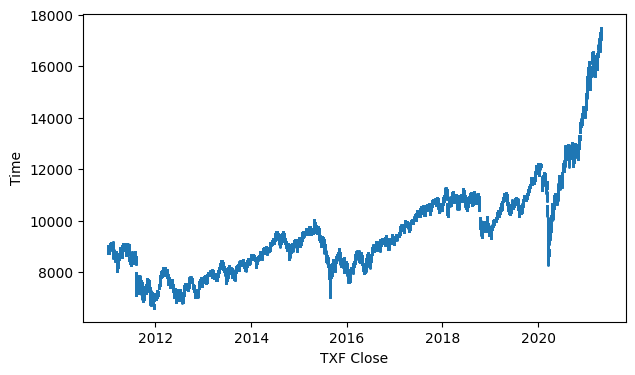

In [10]:
draw_plot(TXF_train.index, TXF_train.Close, 'TXF Close', 'Time')

### Dataset and DataLoader

In [11]:
## Dataset and DataLoader
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, TXF, TSMC = None):
        self.TXF = torch.cat((
            torch.unsqueeze(torch.tensor(TXF.Open.values), 1),
            torch.unsqueeze(torch.tensor(TXF.High.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Low.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Close.values), 1),
            torch.unsqueeze(torch.tensor(TXF.Volume.values), 1)
        ), 1)
        # self.TSMC = torch.unsqueeze(torch.tensor(TSMC.Close.values), 1)
        # print(self.TXF.shape)
        # print(self.TSMC.shape)

        self.TXF_close = torch.unsqueeze(torch.tensor(TXF.Close.values), 1).double()
        # print(self.TXF_close.shape)

        self.data_len = self.TXF.shape[0]

        self.sma_short = ta.SMA(TXF.Close, timeperiod = 3)
        self.sma_short = torch.tensor(np.nan_to_num(self.sma_short, nan = self.sma_short.iloc[2]))
        self.sma_short = torch.unsqueeze(self.sma_short, 1)

        self.sma_long = ta.SMA(TXF.Close, timeperiod = 9)
        self.sma_long = torch.tensor(np.nan_to_num(self.sma_long, nan = self.sma_long.iloc[8]))
        self.sma_long = torch.unsqueeze(self.sma_long, 1)

        self.adosc = ta.ADOSC(TXF.High, TXF.Low, TXF.Close, TXF.Volume, fastperiod = 6, slowperiod = 15)
        self.adosc = torch.tensor(np.nan_to_num(self.adosc, nan = self.adosc.iloc[14]))
        self.adosc = torch.unsqueeze(self.adosc, 1)

        self.bband_upper, self.bband_middle, self.bband_lower = ta.BBANDS(TXF.Close, timeperiod = 20, nbdevup = 2, nbdevdn = 2)

        self.bband_upper = torch.tensor(np.nan_to_num(self.bband_upper, nan = self.bband_upper.iloc[19]))
        self.bband_upper = torch.unsqueeze(self.bband_upper, 1)

        self.bband_middle = torch.tensor(np.nan_to_num(self.bband_middle, nan = self.bband_middle.iloc[19]))
        self.bband_middle = torch.unsqueeze(self.bband_middle, 1)

        self.bband_lower = torch.tensor(np.nan_to_num(self.bband_lower, nan = self.bband_lower.iloc[19]))
        self.bband_lower = torch.unsqueeze(self.bband_lower, 1)

        self.keltner_upper, self.keltner_middle, self.keltner_lower = keltner_bands(TXF.Close, TXF.High, TXF.Low, 20, 1.5)
        self.keltner_upper = torch.tensor(self.keltner_upper)
        self.keltner_upper = torch.unsqueeze(self.keltner_upper, 1)

        self.keltner_middle = torch.tensor(self.keltner_middle)
        self.keltner_middle = torch.unsqueeze(self.keltner_middle, 1)

        self.keltner_lower = torch.tensor(self.keltner_lower)
        self.keltner_lower = torch.unsqueeze(self.keltner_lower, 1)

        self.K, self.D, self.J = KDJ(TXF.High, TXF.Low, TXF.Close, 9, 3, 3)
        self.K = torch.tensor(self.K)
        self.K = torch.unsqueeze(self.K, 1)

        self.D = torch.tensor(self.D)
        self.D = torch.unsqueeze(self.D, 1)

        self.J = torch.tensor(self.J)
        self.J = torch.unsqueeze(self.J, 1)

    def __len__(self):
        return self.data_len - (SEQ_LEN + MIN_LATER + 1) - 1
    
    def __getitem__(self, idx):
        x_data = torch.cat((
            self.TXF[idx : idx + SEQ_LEN],
            # self.TSMC[idx : idx + SEQ_LEN],
            self.sma_short[idx : idx + SEQ_LEN],
            self.sma_long[idx : idx + SEQ_LEN],
            self.adosc[idx : idx + SEQ_LEN],
            self.bband_upper[idx : idx + SEQ_LEN],
            self.bband_middle[idx : idx + SEQ_LEN],
            self.bband_lower[idx : idx + SEQ_LEN],
            self.keltner_upper[idx : idx + SEQ_LEN],
            self.keltner_middle[idx : idx + SEQ_LEN],
            self.keltner_lower[idx : idx + SEQ_LEN],
            self.K[idx : idx + SEQ_LEN],
            self.D[idx : idx + SEQ_LEN],
            self.J[idx : idx + SEQ_LEN]
        ), 1)

        y_data = self.TXF_close[idx + SEQ_LEN + MIN_LATER + 1]

        return x_data, y_data
    
train_valid_dataset = custom_dataset(TXF_train_and_valid)
    
# train_dataset = custom_dataset(TXF_train)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True)

# valid_dataset = custom_dataset(TXF_valid)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True)

test_dataset = custom_dataset(TXF_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True)

Calculating kelner bands : 100%|██████████| 708780/708780 [08:29<00:00, 1390.07it/s] 


In [28]:
test = iter(torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False))
# test = iter(torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False))
test_x, test_y = next(test)
FEATURE_NUM = test_x.shape[2]

print(f'In every data: ')
print(f'\tx_data shape: {test_x[0].shape}')
print(f'\ty_data shape: {test_y[0].shape}\n')
print(f'Which means we use the past [{SEQ_LEN}] minutes data to predict the price in [{MIN_LATER}] minutes later')

In every data: 
	x_data shape: torch.Size([120, 17])
	y_data shape: torch.Size([1])

Which means we use the past [120] minutes data to predict the price in [15] minutes later


In [29]:
print(test_x.shape)
print(test_y.shape)

torch.Size([32, 120, 17])
torch.Size([32, 1])


## Model

### Model implementation

#### Position embedding layer

In [30]:
class PositionEmbedding(torch.nn.Module):
    def __init__(self, d_model: int) -> None:
        super(PositionEmbedding, self).__init__()
        self.linear = torch.nn.Linear(FEATURE_NUM, d_model, dtype = torch.double)

        # Create a matrix of shape (max_len, feature_num)
        pe = torch.zeros(SEQ_LEN, d_model)
        position = torch.arange(0, SEQ_LEN, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Add a batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = self.linear(x)
        x = x + self.pe[:, :x.size(1)]
        return x

#### Multi-head attention layer

In [31]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int) -> None:
        super(MultiHeadAttention, self).__init__()
        
        # d_model should be divisible by num_heads
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.V_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.K_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.Q_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)
        self.output_linear = torch.nn.Linear(d_model, d_model, dtype = torch.double)

    def scaled_dot_product_attention(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor) -> torch.tensor:
        # Q, V: [batch_size, num_heads, seq_len, d_k]
        # K: [batch_size, num_heads, seq_len, d_k] -> K: [batch_size, num_heads, d_k, seq_len]
        # attention: [batch_size, num_heads, seq_len, seq_len]
        attention = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k).float())

        # attention_prob: [batch_size, num_heads, seq_len, seq_len]
        # It satisfies the sum of the last dimension is 1
        # For example, assume the result of this softmax is a
        # then a[0][0][0][0] + a[0][0][0][1] + ... + a[0][0][0][seq_len - 1] = 1
        attention_prob = torch.nn.functional.softmax(attention, dim = -1)
        output = torch.matmul(attention_prob, V)
        return output
    
    def split_heads(self, x: torch.tensor) -> torch.tensor:
        batch_size, seq_len, d_model = x.size()

        # x: [batch_size, seq_len, d_model] -> x: [batch_size, num_heads, seq_len, d_k]
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        return x
    
    def concat_heads(self, x: torch.tensor) -> torch.tensor:
        batch_size, _, seq_len, d_k = x.size()

        # x: [batch_size, num_heads, seq_len, d_k] -> x: [batch_size, seq_len, d_model]
        x = x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return x
    
    def forward(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor) -> torch.tensor:
        Q = self.split_heads(self.Q_linear(Q))
        K = self.split_heads(self.K_linear(K))
        V = self.split_heads(self.V_linear(V))
        # print("-> Split head succeeded!")

        attention_output = self.scaled_dot_product_attention(Q, K, V)
        # print("-> Scaled dot product attention succeeded!")

        output = self.output_linear(self.concat_heads(attention_output))
        # print("-> Concat head succeeded!")
        
        return output

#### Feed forward layer

In [32]:
class FeedForward(torch.nn.Module):
    def __init__(self, d_model: int, d_ff: int) -> None:
        super(FeedForward, self).__init__()
        # self.fully_connected_1 = torch.nn.Linear(d_model, d_ff, dtype = torch.double)
        # self.fully_connected_2 = torch.nn.Linear(d_ff, d_model, dtype = torch.double)
        self.conv1d_1 = torch.nn.Conv1d(in_channels = d_model, out_channels = d_ff, kernel_size = 1, dtype = torch.double)
        self.conv1d_2 = torch.nn.Conv1d(in_channels = d_ff, out_channels = d_model, kernel_size = 1, dtype = torch.double)
        self.relu = torch.nn.ReLU()

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = x.transpose(1, 2)
        nonliear_output_1 = self.relu(self.conv1d_1(x))
        output = self.conv1d_2(nonliear_output_1)
        return output.transpose(1, 2)


#### Encoder layer

In [33]:
class Encoder(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout_rate: int) -> None:
        super(Encoder, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_model * 4)
        self.norm_1 = torch.nn.LayerNorm(d_model, dtype = torch.double)
        self.norm_2 = torch.nn.LayerNorm(d_model, dtype = torch.double)
        self.dropout = torch.nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # print("Start to encode...")
        attention_output = self.multi_head_attention(x, x, x)
        # print("Get the attention output!\n")

        # print("Start to feed forward...")
        feed_forward_input = self.norm_1(x + self.dropout(attention_output))
        feed_forward_output = self.feed_forward(feed_forward_input)
        output = self.norm_2(feed_forward_input + self.dropout(feed_forward_output))
        # print("Get the feed forward output!\n")
        
        return output

#### Transformer model

In [34]:
class Transformer(torch.nn.Module):
    def __init__(self, d_model: int, num_heads: int, num_layers: int, dropout_rate: int) -> None:
        super(Transformer, self).__init__()
        self.d_model = d_model

        self.position_embedding = PositionEmbedding(d_model)
        self.encoder = torch.nn.ModuleList([Encoder(d_model, num_heads, dropout_rate) for _ in range(num_layers)])
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.prepare_output = torch.nn.Linear(SEQ_LEN * D_MODEL, 64, dtype = torch.double)
        self.relu = torch.nn.ReLU()
        self.final_layer = torch.nn.Linear(64, 1, dtype = torch.double)

    def forward(self, x):
        x = self.position_embedding(x)

        encoder_output = x
        for encoder in self.encoder:
            encoder_output = encoder(encoder_output)

        encoder_output = encoder_output.view(encoder_output.shape[0], -1)

        # [batch_size, seq_len] -> [batch_size, 64]
        flatten_encoder_output = self.dropout(self.prepare_output(encoder_output))

        output = self.final_layer(flatten_encoder_output)
        return output

### Define Model

In [35]:
def init_model():
    transformer = Transformer(
        d_model = D_MODEL,
        num_heads = NUM_HEADS,
        num_layers = NUM_ENCODER_LAYERS,
        dropout_rate = DROPOUT_RATE
    ).to(device = DEVICE)

    criterion = torch.nn.MSELoss().to(device = DEVICE)
    optimizer = torch.optim.Adam(transformer.parameters(), lr = LEARNING_RATE, betas=(0.9, 0.98), eps=1e-8, weight_decay = 0.02)

    return transformer, criterion, optimizer

transformer, criterion, optimizer = init_model()

In [36]:
torch.cuda.device(0)
torch.cuda.empty_cache()
torch.cuda.set_device(0)

transformer.train()

Transformer(
  (position_embedding): PositionEmbedding(
    (linear): Linear(in_features=17, out_features=6, bias=True)
  )
  (encoder): ModuleList(
    (0-5): 6 x Encoder(
      (multi_head_attention): MultiHeadAttention(
        (V_linear): Linear(in_features=6, out_features=6, bias=True)
        (K_linear): Linear(in_features=6, out_features=6, bias=True)
        (Q_linear): Linear(in_features=6, out_features=6, bias=True)
        (output_linear): Linear(in_features=6, out_features=6, bias=True)
      )
      (feed_forward): FeedForward(
        (conv1d_1): Conv1d(6, 24, kernel_size=(1,), stride=(1,))
        (conv1d_2): Conv1d(24, 6, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (norm_1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (prepare_output): Linear(in_features=720, out_features

### Start Train and Validate

#### Early stop

In [ ]:
class early_stopper:
    def __init__(self, patience: int, min_delta_percentage: float) -> None:
        self.patience = patience
        self.min_delta_percentage = min_delta_percentage
        self.counter = 0
        self.best_vloss = None
        self.best_model_path = None

    def update(self, new_best_vloss: float, model: torch.nn.Module) -> None:
        self.counter = 0
        self.best_vloss = new_best_vloss

        if os.path.exists(self.best_model_path):
            os.remove(self.best_model_path)
        self.best_model_path = f'model_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.pth'
        torch.save(model.state_dict(), self.best_model_path)

    def __call__(self, vloss: float, model: torch.nn.Module) -> bool:
        if self.best_vloss is None:
            self.update(vloss, model)
            return False

        if vloss < self.best_vloss:
            self.update(vloss, model)
            return False
        
        elif vloss > self.best_vloss * (1 + self.min_delta_percentage):
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


#### Classic train-validate

In [37]:
# best_average_vloss = float('inf')
# model_path = ""

# for epoch in range(EPOCHS):
#     transformer.train()

#     epoch_loss = 0
#     for x_data, y_data in tqdm(train_dataloader, desc = f'Epoch: {epoch + 1}, Training...'):
#         x_data = x_data.to(device = DEVICE)
#         y_data = y_data.to(device = DEVICE)

#         optimizer.zero_grad()
#         output = transformer(x_data)
#         loss = criterion(output, y_data)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     avg_epoch_loss = epoch_loss / TXF_train.shape[0]
#     print(f'Epoch: {epoch + 1}, Average Loss: {avg_epoch_loss}')
#     wandb.log({'loss': epoch_loss})
#     wandb.log({'average_loss': avg_epoch_loss})

#     transformer.eval()
#     epoch_vloss = 0
#     with torch.no_grad():
#         for x_data, y_data in tqdm(valid_dataloader, desc = f'Epoch: {epoch + 1}, Validating...'):
#             x_data = x_data.to(device = DEVICE)
#             y_data = y_data.to(device = DEVICE)

#             voutput = transformer(x_data)
#             vloss = criterion(output, y_data)
#             epoch_vloss += vloss.item()
    
#     avg_epoch_vloss = epoch_vloss / TXF_valid.shape[0]
#     print(f'Epoch: {epoch + 1}, Average Validation Loss: {avg_epoch_vloss}\n')
#     wandb.log({'validation_loss': epoch_vloss})
#     wandb.log({'average_validation_loss': avg_epoch_vloss})

#     if avg_epoch_vloss < best_average_vloss:
#         if os.path.exists(model_path):
#             os.remove(model_path)

#         best_average_vloss = avg_epoch_vloss
#         model_path = f'model_{epoch + 1}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.pth'
#         torch.save(transformer.state_dict(), model_path)


: 

#### K-Fold Cross Validation

In [ ]:
def train_model(epoch: int, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, device: str) -> None:
    model.to(device = device)
    model.train()

    tloss = 0.0
    for x_data, y_data in tqdm(dataloader, desc = f'{epoch + 1}: training...', position = 0):
        x_data = x_data.to(device = device)
        y_data = y_data.to(device = device)

        optimizer.zero_grad()
        output = model(x_data)
        loss = criterion(output, y_data)
        loss.backward()
        optimizer.step()
        tloss += loss.item()

    average_tloss = tloss / len(dataloader.dataset)
    print(f'Epoch: {epoch + 1}, Average Loss: {average_tloss}')
    wandb.log({'loss': tloss})
    wandb.log({'average_loss': average_tloss})

In [ ]:
def validate_model(epoch: int, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, criterion: torch.nn.Module, device: str) -> float:
    model.to(device = device)
    model.eval()

    vloss = 0.0
    with torch.no_grad():
        for x_data, y_data in tqdm(dataloader, desc = f'{epoch + 1}: validating...', position = 1):
            x_data = x_data.to(device = device)
            y_data = y_data.to(device = device)

            output = model(x_data)
            loss = criterion(output, y_data)
            vloss += loss.item()

    average_vloss = vloss / len(dataloader.dataset)
    print(f'Epoch: {epoch + 1}, Average Validation Loss: {average_vloss}\n')
    wandb.log({'validation_loss': vloss})
    wandb.log({'average_validation_loss': average_vloss})

    return average_vloss

In [ ]:
kfold = KFold(n_splits = K, shuffle = True)
for fold, (train_index, valid_index) in enumerate(kfold.split(train_valid_dataset)):
    print(f'Fold: {fold + 1}')
    
    train_subsampler = torch.utils.data.Subset(train_valid_dataset, train_index)
    valid_subsampler = torch.utils.data.Subset(train_valid_dataset, valid_index)

    train_loader = torch.utils.data.DataLoader(train_subsampler, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True)
    valid_loader = torch.utils.data.DataLoader(valid_subsampler, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, drop_last = True)

    transformer, criterion, optimizer = init_model()
    early_stop = early_stopper(patience = 5, min_delta_percentage = 0.05)
    torch.cuda.empty_cache()

    # training loop
    for epoch in range(EPOCHS):
        train_model(model = transformer, dataloader = train_loader, criterion = criterion, optimizer = optimizer, device = DEVICE)

        average_vloss = validate_model(model = transformer, dataloader = valid_loader, criterion = criterion, device = DEVICE)
        if early_stop(average_vloss, transformer):
            break

    print('=' * 50)

### Load the best model in training and predict one of the data in test dataset

In [ ]:
# print(model_path)
# transformer = Transformer(
#     d_model = D_MODEL,
#     num_heads = NUM_HEADS,
#     num_layers = NUM_ENCODER_LAYERS,
#     dropout_rate = DROPOUT_RATE
# ).to(device = DEVICE)

# transformer.load_state_dict(torch.load(model_path, weights_only = True))
# transformer.eval()

# test = iter(test_dataloader)
# test_x, test_y = next(test)
# test_output = transformer(test_x.to(device = DEVICE))
# test_y = test_y.to(device = DEVICE)

# print(f'Average difference: {torch.mean(test_output - test_y)}')
# print(f'Minimum difference: {torch.min(abs(test_output - test_y))}')
# print(f'Maximum difference: {torch.max(abs(test_output - test_y))}')
# for i in range(test_output.shape[0]):
#     print(f'Predicted: {test_output[i].item()}, \tTrue: {test_y[i].item()}, \tdiffernece: {test_output[i].item() - test_y[i].item()}')

In [ ]:
# test2_path = 'data/TXFR1_1min.csv'
# test2 = pd.read_csv(test2_path)
# test2.index = pd.to_datetime(test2.ts)
# test2 = test2.loc[test2.ts.between('2023-12-09', '2024-08-16')]

# test2_dataset = custom_dataset(test2)
# test2_dataloader = torch.utils.data.DataLoader(test2_dataset, batch_size = BATCH_SIZE, shuffle = False, pin_memory = True, drop_last = True)

# test2 = iter(test2_dataloader)
# test2_x, test2_y = next(test2)
# test2_output = transformer(test2_x.to(device = DEVICE))
# test2_y = test2_y.to(device = DEVICE)

# print(f'Average difference: {torch.mean(test2_output - test2_y)}')
# print(f'Minimum difference: {torch.min(abs(test2_output - test2_y))}')
# print(f'Maximum difference: {torch.max(abs(test2_output - test2_y))}')
# for i in range(test2_output.shape[0]):
#     print(f'Predicted: {test2_output[i].item()}, \tTrue: {test2_y[i].item()}, \tdiffernece: {test2_output[i].item() - test2_y[i].item()}')